In [56]:
import pandas as pd
import chordparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [57]:
percentages = []

In [58]:
# # this file does not contain any chords
# os.remove('data/Country/Tim Mcgraw-Taylor Swift')

In [59]:
cp = chordparser.Parser()
CE = chordparser.ChordEditor()
CRC = chordparser.ChordRomanConverter()

In [60]:
sharps_to_flats = {
    'C#': 'Db',
    'D#': 'Eb',
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
}

In [61]:
lower_base = {
    'C': 'B',
    'B': 'Bb',
    'Bb': 'A',
    'A': 'Ab',
    'Ab': 'G',
    'G': 'Gb',
    'Gb': 'F',
    'F': 'E',
    'E': 'Eb',
    'Eb': 'D',
    'D': 'Db',
    'Db': 'C'
}

In [62]:
def key_detector(df, key):
    scale = cp.create_scale(key)
    
    in_scale = 0
    chords = []

    for i, note in enumerate(scale._get_notes()):
        if key.mode == 'major':
            if i == 0 or i == 4 or i == 5:
                chords.append(CE.create_chord(note.value))
            else:
                chords.append(CE.create_chord(note.value + 'm'))

        if key.mode == 'minor':
            if i == 3 or i == 6 or i == 7:
                chords.append(CE.create_chord(note.value))
            else:
                chords.append(CE.create_chord(note.value + 'm'))

    for i, row in df.iterrows():
        current_cord = CE.create_chord(row['from'])
        if current_cord in chords:
            in_scale += 1

    return in_scale / len(df)

In [63]:
def process_song(file):
    # dataframe
    df = pd.read_csv(file, delimiter='\t', skiprows=2, header=None)
    df.columns=['from', 'to']
    
    percent_in_scale = 1.0

    # signature
    with open(file, "r") as fin:
        signature = fin.readlines()[:2]
        
    base = re.split(':|\\n', signature[0])[1]
    capo = re.split(':|\\n', signature[1])[1]
    
    if capo == 'None':
        capo = 0
    else:
        capo = int(capo)

    # key and scale
    if('m' in base):
        mode = 'minor'
        base = base.replace('m', '')
    else:
        mode = 'major'
        
    if base in sharps_to_flats.keys() and base != df['from'][0].replace('m', ''):
        base = sharps_to_flats[base]  

    for i in range(capo):
        base = lower_base[base]
    
    key = cp.create_key(base, mode)

    df['from'] = df['from'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))
    df['to'] = df['to'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))

    # convert to roman
    if base in sharps_to_flats.keys():
        base = sharps_to_flats[base]  
        
    df['from_roman'] = df['from'].apply(lambda x: CRC.to_roman(CE.create_chord(x),key))
    df['to_roman'] = df['to'].apply(lambda x: CRC.to_roman(CE.create_chord(x),key))

    if df['from_roman'][0] != 'i' and df['from_roman'][0] != 'I':
        global not_i
        not_i += 1
        percent_in_scale = key_detector(df,key)
    
    if(percent_in_scale < 1):
        print('Not completely in scale:', file)

    return df, percent_in_scale

In [64]:
directory = 'data/'
not_i = 0
total_songs = 0

percentages = []
out_of_key = {}

for subdir, dirs, files in os.walk(directory):
    for i, filename in enumerate(os.listdir(subdir)):
        f = os.path.join(subdir, filename)
        if os.path.isfile(f):
            df, in_scale = process_song(f)
            percentages.append(df)
            out_of_key[f] = in_scale
            total_songs += 1

print('-----')

Not completely in scale: data/Electronic/One More Light-Linkin Park
Not completely in scale: data/Electronic/Girls Like You-Maroon 5
Not completely in scale: data/Electronic/Dying In La-Panic At the Disco
Not completely in scale: data/Electronic/Want You Back-5 Seconds Of Summer
Not completely in scale: data/Electronic/Middle-DJ Snake
Not completely in scale: data/Electronic/Sharp Edges-Linkin Park
Not completely in scale: data/Electronic/Virtual Insanity-Jamiroquai
Not completely in scale: data/Electronic/Royals-Lorde
Not completely in scale: data/Electronic/Fireflies-Owl City
Not completely in scale: data/Electronic/Clarity-Zedd
Not completely in scale: data/Electronic/Sorry-Halsey
Not completely in scale: data/Electronic/Chandelier-Sia
Not completely in scale: data/Electronic/High Hopes-Panic At the Disco
Not completely in scale: data/Electronic/Liability-Lorde
Not completely in scale: data/Electronic/Ghost Of You-5 Seconds Of Summer
Not completely in scale: data/Rock/Proud Mary-Cre

# Amount of chords not in scale

In [65]:
print(not_i)
print(total_songs)

122
382


Text(0.5, 1.0, 'Percent of songs’ chords in scale')

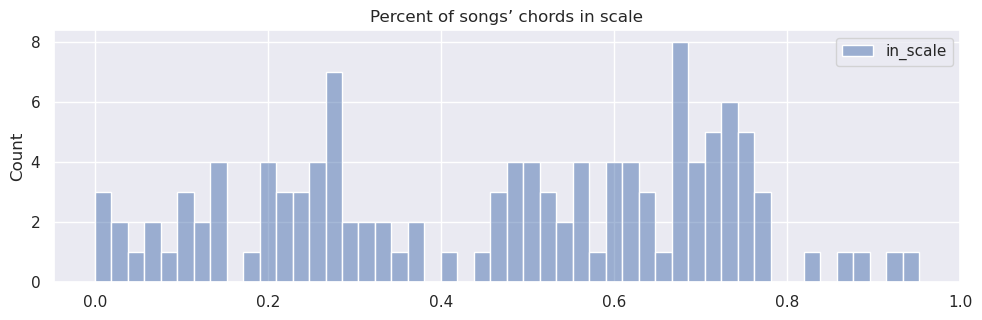

In [66]:
sns.set(rc={'figure.figsize':(11.7,3.27)})
df_scale = pd.DataFrame({'song': out_of_key.keys(), 'in_scale': out_of_key.values()})
sns.histplot(df_scale[df_scale['in_scale'] < 1], bins=50, color='grey')
plt.title('Percent of songs’ chords in scale')